# Introduction
**Description du Projet** : S'informer auprès des données de la banque mondiale et identifer les marchés potentiels pour l'expansion à l'international.

Le présent notebook comporte les manipulations, les analyses détaillées et les visualistion des données.

#  Importer des Libraries et des Données

In [1]:
# Import libraries
import pickle
import warnings

import folium
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from pandas.core.common import SettingWithCopyWarning

pd.set_option('display.max_colwidth', 70)
sns.set_theme(style="whitegrid")
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# Import Data into 5 dataframes
df_footnote = pd.read_csv("./data/EdStatsFootNote.csv")
df_country_series = pd.read_csv("./data/EdStatsCountry-Series.csv")
df_series = pd.read_csv("./data/EdStatsSeries.csv")
df_country = pd.read_csv("./data/EdStatsCountry.csv")
df_data = pd.read_csv("./data/EdStatsData.csv")

In [3]:
# Copy/Backup all dataframes
df_footnote_copy = df_footnote.copy()
df_country_series_copy = df_country_series.copy()
df_series_copy = df_series.copy()
df_country_copy = df_country.copy()
df_data_copy = df_data.copy()

In [4]:
# Create dataframe Dictionary
df_dict = {
    "df_footnote": df_footnote,
    "df_country_series": df_country_series,
    "df_series": df_series,
    "df_country": df_country,
    "df_data": df_data,
}

# Explorer les Données
## Exploration Préliminaire des Données

In [5]:
# Check the size of each dataframe
print("The shape of each dataframe".center(38))
print("===========================".center(38))
for key, value in df_dict.items():
    print(f"{key:>17}: {str(value.shape):>12}\n")

     The shape of each dataframe      
      df_footnote:  (643638, 5)

df_country_series:     (613, 4)

        df_series:   (3665, 21)

       df_country:    (241, 32)

          df_data: (886930, 70)



In [6]:
for df_dict_key, df_dict_value in df_dict.items():
    print(df_dict_key)
    print("======================================================")
    print(df_dict[df_dict_key].info())
    print("\n")

df_footnote
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643638 entries, 0 to 643637
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CountryCode  643638 non-null  object 
 1   SeriesCode   643638 non-null  object 
 2   Year         643638 non-null  object 
 3   DESCRIPTION  643638 non-null  object 
 4   Unnamed: 4   0 non-null       float64
dtypes: float64(1), object(4)
memory usage: 24.6+ MB
None


df_country_series
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CountryCode  613 non-null    object 
 1   SeriesCode   613 non-null    object 
 2   DESCRIPTION  613 non-null    object 
 3   Unnamed: 3   0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 19.3+ KB
None


df_series
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3665 entries, 0 to 3664

In [7]:
df_data_CountryCode_values = df_dict["df_data"]["Country Code"]
df_country_CountryCode_values = df_dict["df_country"]["Country Code"]

print(
    f"The number of unique countries in df_data: ",
    f"{df_data_CountryCode_values.nunique(): >6}",
)
print(
    f"The number of unique countries in df_country: ",
    f"{df_country_CountryCode_values.nunique()}",
)

df_data_CountryCode_set = set(df_dict["df_data"]["Country Code"])
df_country_CountryCode_set = set(df_dict["df_country"]["Country Code"])

print(
    f"The extra country in df_data is:",
    f"{list(df_data_CountryCode_set - df_country_CountryCode_set)[0]: >16}",
    f"({df_dict['df_data']['Country Name'].loc[df_data_CountryCode_values == 'VGB'].unique()[0]})",
)

The number of unique countries in df_data:     242
The number of unique countries in df_country:  241
The extra country in df_data is:              VGB (British Virgin Islands)


In [8]:
# British Virgin  Islands is not in any other dataframes
print('VBG' in df_dict['df_footnote']['CountryCode'].unique())
print('VBG' in df_dict['df_country_series']['CountryCode'].unique())
print('VBG' in df_dict['df_country']['Country Code'].unique())

False
False
False


**<ins> Remarques Préliminaires </ins>**<br><br>
**Généralités**
- Il y a une colonne supplémentaire ajoutée à la fin de chaque dataframe lors de l'importation : A supprimer
- Il y a quelques valeurs nulles, notamment dans ``df_country``, ``df_data`` et ``df_series``.

**Dataframes Spécifiques**<br>
**'df_footnote'** - contient les infos de description des différentes combinaisons de ``CountryCode`` et de ``SeriesCode`` dans différentes années <br>
**'df_country_series'** - contient les infos de description de différentes combinaisons de ``CountryCode`` et ``SeriesCode`` <br>
**'df_series'** - contient les infos détaillées des séries/indicateurs. Il y a 3 665 indicateurs <br>
**'df_country'** - contient les infos détaillées sur les pays. Il y a 241 pays. <br>
**'df_data'** - - 
1. Table principale à utiliser. Utiliser ```Indicator Name``` or ```Indicator Code``` pour trouver/filtrer l'indicateur pertinent à analyser.
2. Données jusqu'à l'année 2017. Ensuite, projection des données tous les 5 ans.
3. Il y a 242 (pays) x 3 665 (indicateurs) = 886 930 combinaisons de pays et d'indicateurs.
    - Il y a un pays, les îles Vierges britanniques (VGB), qui n'est pas dans ``df_country`` ni dans aucun autre dataframes.

## Nettoyage Préliminaire des Données
Comme il y a des valeurs nulles dans les dataframes, il est préférable de les supprimer d'abord. Ainsi, il rendre plus facilement à se concentrer sur les données utiles. <br>
À l'exception de ```df_data```, supprimer les colonnes dont le taux de remplissage est inférieur à 75 %. <br>
Pour l'instant, besoin d'explorer davantage plus tard sur ```df_data``` avant de décider comment nettoyer ce dataframe.

In [9]:
# # Restore dataframes if needed
# df_dict = {
#     "df_footnote": df_footnote_copy.copy(),
#     "df_country_series": df_country_series_copy.copy(),
#     "df_series": df_series_copy.copy(),
#     "df_country": df_country_copy.copy(),
#     "df_data": df_data_copy.copy(),
# }

In [10]:
def drop_null(df, unfilled_rate=0.75):
    n_rows = len(df)
    for (columnName, columnData) in df.iteritems():
        if df[columnName].isnull().sum()/n_rows > unfilled_rate:
            df.drop(columns=columnName, inplace=True)   
    return df

In [11]:
unfilled_rate = 0.75

for df_dict_key, df_dict_value in df_dict.items():
    print(df_dict_key)
    print("===========")
    print(f"Original shape: {str(df_dict_value.shape) : >13}")
    if df_dict_key == "df_data":
        # Remove only the last column.
        df_dict["df_data"].drop(columns=df_dict["df_data"].columns[-1], inplace=True)
    else:
        # Remove columns that have less than 75% filled rate.
        df_dict_value = drop_null(df_dict_value, unfilled_rate)
    print(f"New shape: {str(df_dict_value.shape) : >18} \n")

    # Convert column names to camel case and then remove space for easier manoeuver.
    df_dict_value.columns = [
        col.title().replace(" ", "") for col in df_dict_value.columns
    ]

df_footnote
Original shape:   (643638, 5)
New shape:        (643638, 4) 

df_country_series
Original shape:      (613, 4)
New shape:           (613, 3) 

df_series
Original shape:    (3665, 21)
New shape:          (3665, 6) 

df_country
Original shape:     (241, 32)
New shape:          (241, 28) 

df_data
Original shape:  (886930, 70)
New shape:       (886930, 69) 



In [12]:
# Back up dataframes with columns that are more than 75% filled rate.
df_dict_prelim_clean = df_dict.copy()

In [13]:
# # Check dataframes infos
# for df_dict_key, df_dict_value in df_dict.items():
#     print(df_dict_key)
#     print("======================================================")
#     print(df_dict[df_dict_key].info())
#     print("\n")

### Aperçu les Dataframes

In [14]:
df_dict['df_footnote'].head()

,Countrycode,Seriescode,Year,Description
0,ABW,SE.PRE.ENRL.FE,YR2001,Country estimation.
1,ABW,SE.TER.TCHR.FE,YR2005,Country estimation.
2,ABW,SE.PRE.TCHR.FE,YR2000,Country estimation.
3,ABW,SE.SEC.ENRL.GC,YR2004,Country estimation.
4,ABW,SE.PRE.TCHR,YR2006,Country estimation.


In [15]:
df_dict['df_country_series'].head()

,Countrycode,Seriescode,Description
0,ABW,SP.POP.TOTL,Data sources : United Nations World Population Prospects
1,ABW,SP.POP.GROW,Data sources: United Nations World Population Prospects
2,AFG,SP.POP.GROW,Data sources: United Nations World Population Prospects
3,AFG,NY.GDP.PCAP.PP.CD,Estimates are based on regression.
4,AFG,SP.POP.TOTL,Data sources : United Nations World Population Prospects


In [16]:
df_dict['df_series'].head(3)

,SeriesCode,Topic,IndicatorName,ShortDefinition,LongDefinition,Source
0,BAR.NOED.1519.FE.ZS,Attainment,Barro-Lee: Percentage of female population age 15-19 with no educa...,Percentage of female population age 15-19 with no education,Percentage of female population age 15-19 with no education,Robert J. Barro and Jong-Wha Lee: http://www.barrolee.com/
1,BAR.NOED.1519.ZS,Attainment,Barro-Lee: Percentage of population age 15-19 with no education,Percentage of population age 15-19 with no education,Percentage of population age 15-19 with no education,Robert J. Barro and Jong-Wha Lee: http://www.barrolee.com/
2,BAR.NOED.15UP.FE.ZS,Attainment,Barro-Lee: Percentage of female population age 15+ with no education,Percentage of female population age 15+ with no education,Percentage of female population age 15+ with no education,Robert J. Barro and Jong-Wha Lee: http://www.barrolee.com/


In [17]:
df_dict['df_country'].head(2)

,CountryCode,ShortName,TableName,LongName,2-AlphaCode,CurrencyUnit,SpecialNotes,Region,IncomeGroup,Wb-2Code,...,GovernmentAccountingConcept,ImfDataDisseminationStandard,LatestPopulationCensus,LatestHouseholdSurvey,SourceOfMostRecentIncomeAndExpenditureData,VitalRegistrationComplete,LatestAgriculturalCensus,LatestIndustrialData,LatestTradeData,LatestWaterWithdrawalData
0,ABW,Aruba,Aruba,Aruba,AW,Aruban florin,SNA data for 2000-2011 are updated from official government statis...,Latin America & Caribbean,High income: nonOECD,AW,...,NaN,NaN,2010,NaN,NaN,Yes,NaN,NaN,2012.0,NaN
1,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period for national accounts ...,South Asia,Low income,AF,...,Consolidated central government,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,NaN,2012.0,2000


In [18]:
df_dict['df_data'].head(2)

,CountryName,CountryCode,IndicatorName,IndicatorCode,1970,1971,1972,1973,1974,1975,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
0,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, both sexes (%)",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, female (%)",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Fonctions Outils

In [19]:
# Helper functions
def count_per_year(df, begin=5, end=None, sum_value=False):
    """
    Plot dataframe

    Parameters
    ----------
    df : dataframe
        The dataframe to be counted
    begin : int, optional, default 5
        An integer to indicate the beginning of a slice.
        This is to indicate which columns in to be included in the count
    end : int, optional, default  None
        An integer to indicate the end of a slice.
        This is to indicate which columns in to be included in the plot
    value_sum : bool, default False
        A flag to indicate to sum real values count non-null values
        If set to True, it sums real values instead of counting non-null values
        
    Returns
    -------
    dataframe
        A  dataframe with counts per year

    """
    
    df_count = pd.DataFrame(columns=['counts'])
    for column in df.columns[begin:end]:
        if sum_value:
            df_count.loc[column] = df[str(column)].sum()
        else:
            df_count.loc[column] = df[str(column)].notnull().sum()
    return df_count

def filter_indicator_by_name(df, keyword):
    """
    Filter dataframe with the indicator name(s) provided

    Parameters
    ----------
    df : dataframe
        The dataframe to be filtered
    keyword : str
        A string of keyword(s) in regex format
        to be used to filter the input dataframe
        Format examples:
            1. 'str1|str2'
            2. '(?=.*str1)(?=.*str2)'

    Returns
    -------
    dataframe
        A filtered dataframe with only indicators
        that contains the input keyword(s)
    """

    return df[df.IndicatorName.str.contains(keyword)]


def insert_evolution(df):
    """
    Calculate the evolution between 2003 and 2016.
    Then add the result in the last column of the dataframe

    Parameters
    ----------
    df : dataframe
        The dataframe to be calculated

    Returns
    -------
    dataframe
        A dataframe with the evolution between 2003 and 2016
        added in the last column
    """

    df["evolution"] = df["2016"] - df["2003"]
    return df


def sort_top_10(df):
    """
    Sort the dataframe by the 'evolution' and '2016' columns
    and get the top 10 countries

    Parameters
    ----------
    df : dataframe
         The dataframe to be sorted

    Returns
    -------
    dataframes
        A dataframe sorted by the 'evolution' column
        Another dataframe sorted by the '2016' column
    """

    df_evolution_top10 = df.sort_values(by=["evolution"], ascending=False).head(10)
    df_2016_top10 = df.sort_values(by=["2016"], ascending=False).head(10)
    return df_evolution_top10, df_2016_top10


def plot_indicator(df, begin=5, end=-1, legend=False):
    """
    Plot dataframe

    Parameters
    ----------
    df : dataframe
        The dataframe to be plotted
    begin : int, optional
        An integer to indicate the beginning of a slice.
        This is to indicate which columns in to be included in the plot
    end : int, optional
        An integer to indicate the end of a slice.
        This is to indicate which columns in to be included in the plot
    legend : bool, default False
        A flag used to show the legend of the graph
        
    Returns
    -------
    ax : matplotlib Axes
        Returns the Axes object with the plot drawn onto it

    """

    plt.figure(figsize=(20, 6))
    # Iterate rows of the dataframe and plot each country
    for index, row in df.iterrows():
        plt.plot(row[begin:end], marker="x", label=row.CountryName)
    # Show legend if the flag is set to True
    if legend:
        plt.legend()
    plt.show()


def get_classic_statistics(df, col):
    """
    Calculate classic statistical indicators for
    different geographical areas and countries of the world

    Parameters
    ----------
    df : dataframe
        The dataframe to be used to calculate the
        classic statistical indicators

    Returns
    -------
    dataframes
        A dataframe with classic statistical indicators group by country
        Another dataframe with classic statistical indicators group by region

    """
    
    describe_region = (
        df.groupby(["Region"])[["2016", "evolution"]]
        .describe()
        .loc[:, (slice(None), ["mean", "std", "50%"])]
        .sort_values([("2016", "mean")], ascending=False)
    )
    
    df_temp = df.drop(columns=col)
    df_temp.set_index('CountryName', drop=True, inplace=True)
    
    describe_country = (
        df_temp.T
        .describe()
        .loc[["mean", "std", "50%"]].T
        .sort_values([("mean")], ascending=False)
    )

    return describe_country, describe_region


def plot_barplot(
    x, y, title=None, xlabel=None, ylabel=None, rotation=0, figsize=(20, 6)
):
    """
    Plot dataframe

    Parameters
    ----------
    x, y : array-like
        The x and y coordinates of data points to be plotted
    title : str, optoinal
        The title of the plot
    xlabel, ylabel : str, optional
        The label of the x- and y-axis respectively
    rotation : int, default 0
        An angle in degree indicating how much xlabel to be rotated
    figsize : tuple in float, defult (20, 6)
        Width, height in inches.
        
    Returns
    -------
    ax : matplotlib Axes
    Returns the Axes object with the plot drawn onto it

    """

    plt.figure(figsize=figsize)
    ax = sns.barplot(x, y)
    plt.title(title, fontdict={"fontsize": 15, "fontweight": "bold"})
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.setp(ax.get_xticklabels(), rotation=rotation)
    plt.show()
    return

## Focus sur ```df_data```
C'est le dataframe principal sur lequel notre analyse va se concentrer.
### Filtrez les Lignes qui ont UNIQUEMENT des Valeurs Nulles

In [20]:
# Focus on df_data
df_data = df_dict['df_data']

In [21]:
# %%time
# # Create mask to filter df_data with rows that have ONLY null values
# mask = [any(df_data.iloc[row,4:].notna()) for row in range(len(df_data))]

In [22]:
# print("df_data")
# print("=======")
# print(f"Original shape: {str(df_data.shape) : >13}")  
# df_data = df_data.iloc[mask]
# df_data.reset_index(drop=True, inplace=True)
# print(f"New shape: {str(df_data.shape) : >18} \n") 

La taille de ```df_data``` est réduite de près de 60% (59,7%). <br>

In [23]:
# Back up the df_data after deleting all the FULL null rows as it takes 7 mins to do so
df_data_no_more_full_null = df_data.copy()

In [24]:
# df_data.to_csv("data/dataframes/df_data_no_more_full_null.csv", index=False)

### Focus sur la Periode Pertinente

In [25]:
df_data = pd.read_csv("data/dataframes/df_data_no_more_full_null.csv")

In [26]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357405 entries, 0 to 357404
Data columns (total 69 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   CountryName    357405 non-null  object 
 1   CountryCode    357405 non-null  object 
 2   IndicatorName  357405 non-null  object 
 3   IndicatorCode  357405 non-null  object 
 4   1970           72288 non-null   float64
 5   1971           35537 non-null   float64
 6   1972           35619 non-null   float64
 7   1973           35545 non-null   float64
 8   1974           35730 non-null   float64
 9   1975           87306 non-null   float64
 10  1976           37483 non-null   float64
 11  1977           37574 non-null   float64
 12  1978           37576 non-null   float64
 13  1979           36809 non-null   float64
 14  1980           89122 non-null   float64
 15  1981           38777 non-null   float64
 16  1982           37511 non-null   float64
 17  1983           38460 non-null

In [27]:
# Create a dataframe with non-null value counts per year
df_data_non_null = pd.DataFrame(columns=['counts'])
for column in df_data.columns[4:]:
    df_data_non_null.loc[column] = df_data[column].notnull().sum()
df_data_non_null.head(3)

,counts
1970,72288
1971,35537
1972,35619


In [28]:
df_data_non_null = count_per_year(df_data, begin=4)

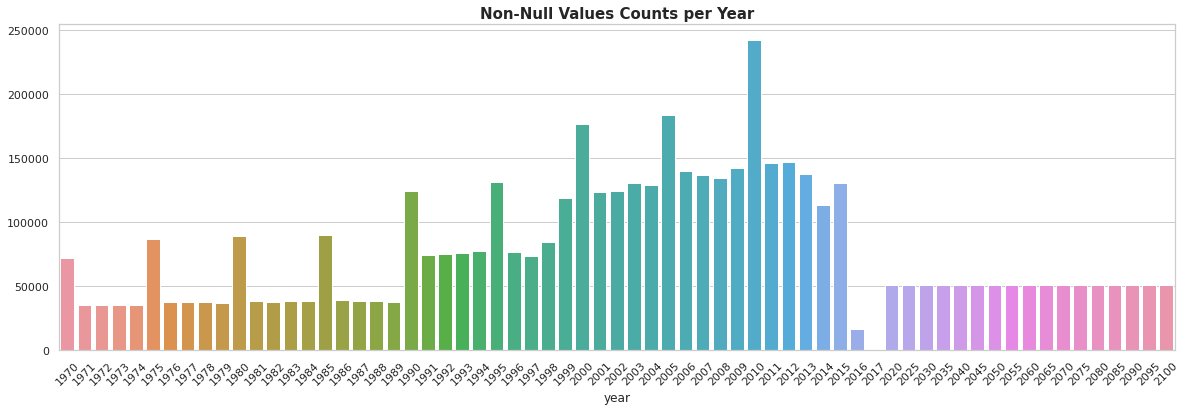

In [29]:
# Plot the number of valid values per year
x = df_data_non_null.index
y = df_data_non_null.counts
title = "Non-Null Values Counts per Year"
xlabel = "year"
plot_barplot(x=x, y=y, title=title, xlabel=xlabel, rotation=45)

On constate que:
- Avant 1999, il y a moins de données. De plus, les données sont également trop anciennes avant 2003, pour notre problème actuel. Donc, peu interrsantes pour notre problèmatique.
- Les données projectées (à partir de 2020) sont très interressantes. Mais on ne suis pas sûr à quel point ces porjections sont fiables. <br>

A cause de cela, seulement les données entre 2003 et 2016 seront été gardées pour la suite.

In [30]:
# Filter and only keep year columns between 2003 and 2016
df_data_1 = df_data.iloc[:,:4]
df_data_2 = df_data.iloc[:,37:51]
df_data = pd.concat([df_data_1, df_data_2], axis=1)

In [31]:
# Back up df_data that contains data only between 2003 and 2006
df_data_2003_2016 = df_data.copy()

In [32]:
# # Restore df_data that contains data only between 2003 and 2006, if needed
# df_data = df_data_2003_2016.copy()

In [33]:
# Check how many indicators do we have
df_data.IndicatorName.nunique()

3665

In [34]:
# Check what indicators do we have and save it in pickle 
# since it is too long to print as list
indicatorName = df_data.IndicatorName.unique().tolist()
file_path = 'data/indicatornamelist_2003_20l6.pkl'
pickle.dump(indicatorName, open(file_path, "wb"))

In [35]:
# Load pickle file and print full list of indicators
print(pickle.load(open(file_path, "rb")))

['Adjusted net enrolment rate, primary, both sexes (%)', 'Adjusted net enrolment rate, primary, female (%)', 'Adjusted net enrolment rate, primary, gender parity index (GPI)', 'Adjusted net enrolment rate, primary, male (%)', 'Adjusted net intake rate to Grade 1 of primary education, both sexes (%)', 'Adjusted net intake rate to Grade 1 of primary education, female (%)', 'Adjusted net intake rate to Grade 1 of primary education, gender parity index (GPI)', 'Adjusted net intake rate to Grade 1 of primary education, male (%)', 'Adult illiterate population, 15+ years, % female', 'Adult illiterate population, 15+ years, both sexes (number)', 'Adult illiterate population, 15+ years, female (number)', 'Adult illiterate population, 15+ years, male (number)', 'Adult literacy rate, population 15+ years, both sexes (%)', 'Adult literacy rate, population 15+ years, female (%)', 'Adult literacy rate, population 15+ years, gender parity index (GPI)', 'Adult literacy rate, population 15+ years, male

### Ajouter des Informations de Région dans ```df_data```

In [36]:
# Take only the 'CountryCode' and 'Region' to merge with df_data
df_country_region_only = df_country[['CountryCode', 'Region']]
df_country_region_only.head(2)

,CountryCode,Region
0,ABW,Latin America & Caribbean
1,AFG,South Asia


In [37]:
# Merge region info in df_data
df_data = pd.merge(df_data, df_country_region_only, how="left", on="CountryCode")
df_data.head(1)

,CountryName,CountryCode,IndicatorName,IndicatorCode,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,Region
0,Arab World,ARB,"Adjusted net enrolment rate, primary, both sexes (%)",SE.PRM.TENR,80.805389,81.607063,82.489487,82.685509,83.280342,84.011871,84.195961,85.211998,85.24514,86.101669,85.51194,85.320152,NaN,NaN,NaN


In [38]:
# Re-arrange columns in df_data
region = df_data['Region']
df_data.drop(labels=['Region'], axis=1,inplace = True)
df_data.insert(4, 'Region', region)
df_data.head(1)

,CountryName,CountryCode,IndicatorName,IndicatorCode,Region,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Arab World,ARB,"Adjusted net enrolment rate, primary, both sexes (%)",SE.PRM.TENR,NaN,80.805389,81.607063,82.489487,82.685509,83.280342,84.011871,84.195961,85.211998,85.24514,86.101669,85.51194,85.320152,NaN,NaN


In [39]:
# Back up df_data that contains region data
df_data_w_region = df_data.copy()

# Analyse des données
Cependant, il y a encore beaucoup trop d'indicateurs à prendre en compte. Pour sélectionner nos clients potentiels, nous allons commencer par regarder ceux qui ont le plus de pouvoir d'achat.
## PIB & PPA

In [40]:
# Look for indicators that provide information about 
# gross domestic product (GDP) based on purchasing power parity (PPP).
df_data[df_data.IndicatorName.str.contains('GDP, PPP')].IndicatorName.unique()

array(['GDP, PPP (constant 2011 international $)',
       'GDP, PPP (current international $)'], dtype=object)

In [41]:
# Set keywords
keyword = '(?=.*GDP, PPP)(?=.*current)'
# Filter dataframe according to the keywords set
df_GDP_PPP = filter_indicator_by_name(df_data, keyword)

In [42]:
# Check if the filtered dataframe is as expected
df_GDP_PPP.IndicatorName.unique()

array(['GDP, PPP (current international $)'], dtype=object)

In [43]:
df_GDP_PPP.IndicatorCode.unique()

array(['NY.GDP.MKTP.PP.CD'], dtype=object)

In [44]:
# Check country names of df_GDP_PPP
df_GDP_PPP.CountryName.unique()

array(['Arab World', 'East Asia & Pacific',
       'East Asia & Pacific (excluding high income)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)', 'European Union',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle income',
       'Middle East & North Africa',
       'Middle East & North Africa (excluding high income)',
       'Middle income', 'North America', 'OECD members', 'South Asia',
       'Sub-Saharan Africa', 'Sub-Saharan Africa (excluding high income)',
       'Upper middle income', 'World', 'Afghanistan', 'Albania',
       'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The',
       'Bahrain', 'Bangladesh', 'Barbados', 'Be

In [45]:
df_GDP_PPP.iloc[24]

CountryName                                   World
CountryCode                                     WLD
IndicatorName    GDP, PPP (current international $)
IndicatorCode                     NY.GDP.MKTP.PP.CD
Region                                          NaN
2003                                    5.62673e+13
2004                                    6.09325e+13
2005                                    6.57254e+13
2006                                    7.20071e+13
2007                                    7.80405e+13
2008                                    8.26379e+13
2009                                    8.34348e+13
2010                                    8.90242e+13
2011                                    9.50631e+13
2012                                    9.99947e+13
2013                                    1.05458e+14
2014                                    1.10806e+14
2015                                     1.1562e+14
2016                                    1.20603e+14
Name: 8732, 

**<ins> Remarques</ins>**<br>
Les 24 premières lignes ne sont pas des pays individuels. Ce sont des régions.

### Analyse des Indicateurs Statistiques Classiques

In [46]:
# Take off the first 24 lines that are not individual countries
df_GDP_PPP_country = df_GDP_PPP.iloc[25:]

In [47]:
# Calculate evolution between 2003 and 2016
df_GDP_PPP_country = insert_evolution(df_GDP_PPP_country)

In [48]:
df_GDP_PPP_country.head(2)

,CountryName,CountryCode,IndicatorName,IndicatorCode,Region,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,evolution
9862,Afghanistan,AFG,"GDP, PPP (current international $)",NY.GDP.MKTP.PP.CD,South Asia,2.128492e+10,2.210105e+10,2.536151e+10,2.759257e+10,3.221907e+10,3.403746e+10,4.150519e+10,4.555511e+10,4.933825e+10,5.750013e+10,5.957345e+10,6.143594e+10,6.291767e+10,6.514279e+10,4.385786e+10
11466,Albania,ALB,"GDP, PPP (current international $)",NY.GDP.MKTP.PP.CD,Europe & Central Asia,1.554698e+10,1.672360e+10,1.789688e+10,1.985489e+10,2.165033e+10,2.425155e+10,2.583185e+10,2.810079e+10,2.965536e+10,3.053034e+10,3.063155e+10,3.274079e+10,3.298144e+10,3.412638e+10,1.857940e+10


In [49]:
# Calculate classic statistic indicators by country and region
columns_to_drop = ["CountryCode", "IndicatorName", "IndicatorCode", "Region"]
describe_GDP_country, describe_GDP_region = get_classic_statistics(
    df_GDP_PPP_country, columns_to_drop
)

In [50]:
describe_GDP_country.head()

,mean,std,50%
CountryName,,,
United States,1.459542e+13,2.903680e+12,1.471858e+13
China,1.267258e+13,5.262893e+12,1.248497e+13
India,5.321138e+12,1.888395e+12,5.312415e+12
Japan,4.317187e+12,8.869618e+11,4.456434e+12
Germany,3.122582e+12,6.538273e+11,3.122546e+12


In [51]:
describe_GDP_region

2016                              \
                                    mean           std           50%   
Region                                                                 
North America               1.011100e+13  1.203988e+13  1.011100e+13   
South Asia                  1.340977e+12  3.001331e+12  1.667670e+11   
East Asia & Pacific         1.261613e+12  3.972664e+12  5.044762e+10   
Europe & Central Asia       5.676662e+11  9.461604e+11  1.899044e+11   
Middle East & North Africa  5.324070e+11  5.490981e+11  3.229314e+11   
Latin America & Caribbean   2.893548e+11  6.885263e+11  4.493250e+10   
Sub-Saharan Africa          8.487239e+10  1.922821e+11  2.936270e+10   

                               evolution                              
                                    mean           std           50%  
Region                                                                
North America               3.845850e+12  4.621586e+12  3.845850e+12  
South Asia                  9.160802e+11  2.115898e+12  1.053375e+11  
East Asia & Pacific         8.054271e+11  2.970678e+12  3.543249e+10  
Europe & Central Asia       2.539951e+11  4.319389e+11  9.404748e+10  
Middle East & North Africa  2.910698e+11  2.896857e+11  1.636521e+11  
Latin America & Caribbean   1.446605e+11  3.207764e+11  2.139561e+10  
Sub-Saharan Africa          5.160846e+10  1.204037e+11  1.619741e+10

### Analyse du Top 10

In [52]:
# Get top 10 countries by evolution and year 2016
df_GDP_PPP_country_evolution_top10, df_GDP_PPP_country_2016_top10 = sort_top_10(
    df_GDP_PPP_country
)

In [53]:
df_GDP_PPP_country_evolution_top10.head(2)

,CountryName,CountryCode,IndicatorName,IndicatorCode,Region,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,evolution
74525,China,CHN,"GDP, PPP (current international $)",NY.GDP.MKTP.PP.CD,East Asia & Pacific,5.103705e+12,5.774280e+12,6.639272e+12,7.713674e+12,9.045939e+12,1.011384e+13,1.114855e+13,1.248497e+13,1.395794e+13,1.533182e+13,1.678803e+13,1.833566e+13,1.985273e+13,2.145097e+13,1.634726e+13
340516,United States,USA,"GDP, PPP (current international $)",NY.GDP.MKTP.PP.CD,North America,1.151067e+13,1.227493e+13,1.309373e+13,1.385589e+13,1.447764e+13,1.471858e+13,1.441874e+13,1.496437e+13,1.551793e+13,1.615526e+13,1.669152e+13,1.739310e+13,1.812071e+13,1.862448e+13,7.113805e+12


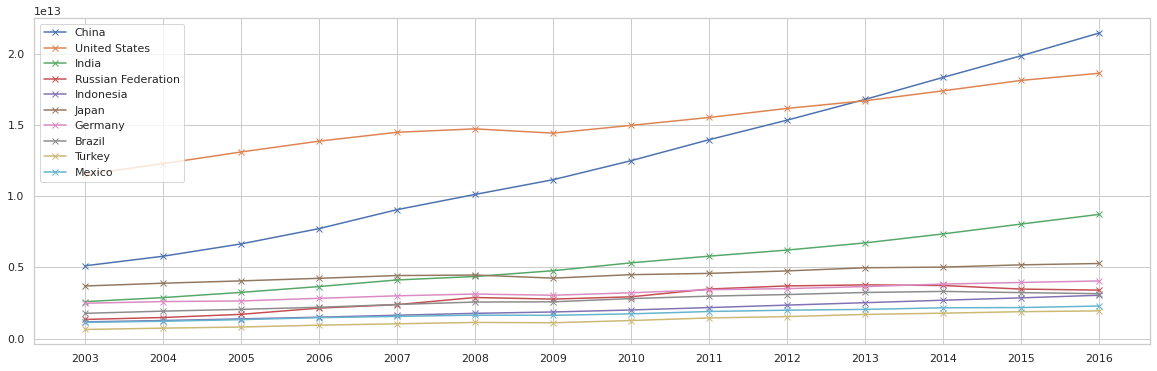

In [54]:
# Visualize top 10 evolved countries
plot_indicator(df_GDP_PPP_country_evolution_top10, legend=True)

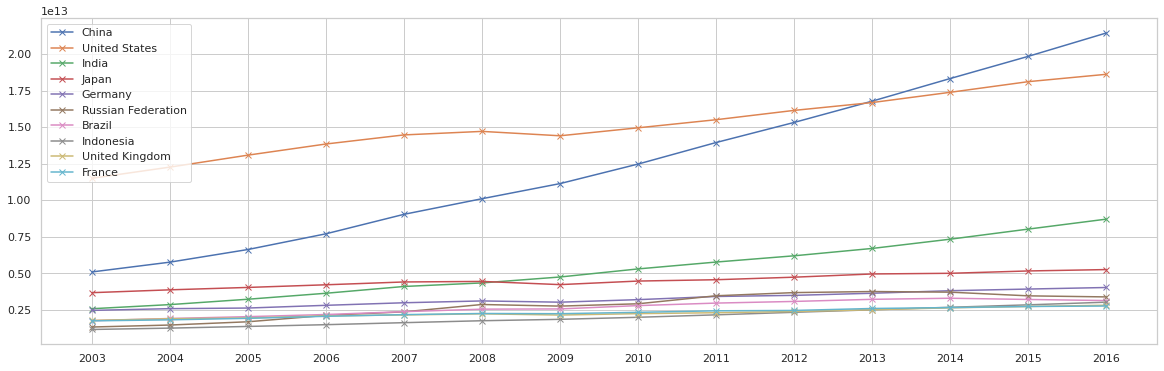

In [55]:
# Visualize top 10 countires in year 2016
plot_indicator(df_GDP_PPP_country_2016_top10, legend=True)

In [56]:
# Countries of df_GDP_PPP that are in the top 10 evolution
df_GDP_PPP_country_evolution_top10_set = set(
    df_GDP_PPP_country_evolution_top10.CountryName
)

# Top 10 Countries of df_GDP_PPP in year 2016
df_GDP_PPP_country_2016_top10_set = set(df_GDP_PPP_country_2016_top10.CountryName)

In [57]:
# Countries that are both top 10 in year 2016 and by evolution
df_GDP_PPP_country_evolution_top10_set & df_GDP_PPP_country_2016_top10_set

{'Brazil',
 'China',
 'Germany',
 'India',
 'Indonesia',
 'Japan',
 'Russian Federation',
 'United States'}

**<ins> Remarques</ins>**<br>
Ces 8 pays (Brésil, Chine, Allemagne, Inde, Indonésie, Japon, Fédération de Russie et Etats-Unis) pourraient être nos marchés potentiels. Mais nous avons besoin d'une analyse plus approfondie pour le vérifier.

## PIB (PPA) par Habitant
L'examen des valeurs du PIB ne suffit pas. Nous devons également examiner les valeurs du PIB par personne pour vérifier le pouvoir d'achat réel des résidents. Pour commencer, nous devons examiner la population de chaque pays.

### Population

In [58]:
# Get all the indicator names
df_data[
    df_data.IndicatorName.str.contains("population|Population")
].IndicatorName.unique()

array(['Adult illiterate population, 15+ years, % female',
       'Adult illiterate population, 15+ years, both sexes (number)',
       'Adult illiterate population, 15+ years, female (number)',
       'Adult illiterate population, 15+ years, male (number)',
       'Adult literacy rate, population 15+ years, both sexes (%)',
       'Adult literacy rate, population 15+ years, female (%)',
       'Adult literacy rate, population 15+ years, gender parity index (GPI)',
       'Adult literacy rate, population 15+ years, male (%)',
       'Population growth (annual %)',
       'Population of the official age for lower secondary education, both sexes (number)',
       'Population of the official age for lower secondary education, female (number)',
       'Population of the official age for lower secondary education, male (number)',
       'Population of the official age for post-secondary non-tertiary education, both sexes (number)',
       'Population of the official age for post-secondary n

**<ins> Remarques </ins>**<br>
Indicateur intéressant : ```Population, total```

In [59]:
# Filter in the population indicator and save it in another dataframe
keyword = 'Population, total'
df_population = filter_indicator_by_name(df_data, keyword)

### Calculer le PIB (PPA) par Habitant

In [60]:
# Numbers of extra countries in the df_population dataframe
# compared to the df_GDP_PPP dataframe
df_population.CountryCode.nunique() - df_GDP_PPP.CountryCode.nunique()

23

In [61]:
# Create a set for the extra countries
extra_countries_set = set(df_population.CountryCode) - set(df_GDP_PPP.CountryCode)
# Use the set to create a filter
extra_countries_filter_str = str(extra_countries_set).replace("', '", "|").strip("{}'")

In [62]:
# Take away extra countires in the df_population dataframe
print(f"df_population size before filter: {df_population.shape}")
# df_population_minus_extra_countries = df_population[
df_population = df_population[
    ~df_population.CountryCode.str.contains(extra_countries_filter_str)
]
print(f"df_population size before filter: {df_population.shape}")

df_population size before filter: (240, 19)
df_population size before filter: (217, 19)


In [63]:
# Double check if df_population and df_GDP_PPP 
# have the same size before the manipulation
df_GDP_PPP.shape

(217, 19)

In [64]:
# Sort both dataframes by 'CountryCode' before the manipulation
df_GDP_PPP.sort_values(by='CountryCode', inplace=True, ignore_index=True)
df_population.sort_values(by='CountryCode', inplace=True, ignore_index=True)

In [65]:
# Double check if the 'CountryCode' of the both dataframes are the same
df_GDP_PPP['CountryCode'].isin(df_population['CountryCode']).value_counts()

True    217
Name: CountryCode, dtype: int64

In [66]:
# Another check
df_compare_CountryCode = pd.concat(
    [df_GDP_PPP.CountryCode, df_population.CountryCode], axis=1
)
df_compare_CountryCode

,CountryCode,CountryCode
0,ABW,ABW
1,AFG,AFG
2,AGO,AGO
3,ALB,ALB
4,ARB,ARB
...,...,...
212,XKX,XKX
213,YEM,YEM
214,ZAF,ZAF
215,ZMB,ZMB


In [67]:
# Calculate GDP (PPP) per capita and store it in df_GDP_PPP_per_capita dataframe
df_GDP_per_capita = df_GDP_PPP.iloc[:,5:] / df_population.iloc[:, 5:]
df_GDP_per_capita.head(2)

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35973.780510,NaN,NaN,NaN,NaN,NaN
1,922.829449,916.334475,1011.595524,1065.619665,1210.479265,1247.066144,1482.098837,1581.600836,1660.739856,1873.153946,1877.411953,1875.447407,1864.973641,1879.695509


In [68]:
# Insert basic info such as 'CountryCode' and 'CountryName' in df_GDP_per_capita
df_GDP_per_capita.insert(loc=0, column="Region", value=df_GDP_PPP.Region)
df_GDP_per_capita.insert(loc=0, column="CountryCode", value=df_GDP_PPP.CountryCode)
df_GDP_per_capita.insert(loc=0, column="CountryName", value=df_GDP_PPP.CountryName)
df_GDP_per_capita.head(2)

,CountryName,CountryCode,Region,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Aruba,ABW,Latin America & Caribbean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35973.780510,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,South Asia,922.829449,916.334475,1011.595524,1065.619665,1210.479265,1247.066144,1482.098837,1581.600836,1660.739856,1873.153946,1877.411953,1875.447407,1864.973641,1879.695509


In [69]:
# Check if it has the expected shape
df_GDP_per_capita.shape

(217, 17)

In [70]:
# Calculate evolution between 2003 and 2016
df_GDP_per_capita = insert_evolution(df_GDP_per_capita)

In [71]:
df_GDP_per_capita.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CountryName  217 non-null    object 
 1   CountryCode  217 non-null    object 
 2   Region       192 non-null    object 
 3   2003         214 non-null    float64
 4   2004         214 non-null    float64
 5   2005         214 non-null    float64
 6   2006         214 non-null    float64
 7   2007         214 non-null    float64
 8   2008         215 non-null    float64
 9   2009         215 non-null    float64
 10  2010         215 non-null    float64
 11  2011         217 non-null    float64
 12  2012         213 non-null    float64
 13  2013         213 non-null    float64
 14  2014         207 non-null    float64
 15  2015         206 non-null    float64
 16  2016         203 non-null    float64
 17  evolution    203 non-null    float64
dtypes: float64(15), object(3)
memory usage: 30.6+ KB


### Analyse des Indicateurs Statistiques Classiques

In [72]:
# Calculate classic statistic indicators by country and region
columns_to_drop = ["CountryCode", "Region"]
(
    describe_GDP_per_capita_country,
    describe_GDP_per_capita_region,
) = get_classic_statistics(df_GDP_per_capita, columns_to_drop)

In [73]:
describe_GDP_per_capita_country.head()

,mean,std,50%
CountryName,,,
Qatar,110955.107472,23886.775107,115012.450334
"Macao SAR, China",89247.861680,31755.297368,77584.571332
Luxembourg,82735.835322,17384.521974,85779.082403
Kuwait,74067.053498,19768.856389,76667.706333
Brunei Darussalam,73434.954495,18912.572728,78682.980825


In [74]:
describe_GDP_per_capita_region

2016                              \
                                    mean           std           50%   
Region                                                                 
North America               50831.671257   9625.827403  50831.671257   
Middle East & North Africa  34276.100326  34728.712324  17382.616727   
Europe & Central Asia       31003.209630  20113.288768  26761.353529   
East Asia & Pacific         22276.702089  27664.251780   8473.477916   
Latin America & Caribbean   14519.257612   7136.865060  14181.405520   
South Asia                   7098.609030   4932.013749   5914.506990   
Sub-Saharan Africa           5329.197440   6715.402712   2571.100890   

                               evolution                              
                                    mean           std           50%  
Region                                                                
North America               14898.541285   4330.915126  14898.541285  
Middle East & North Africa   8501.534762  10716.604447   5421.281354  
Europe & Central Asia       12664.109365   8241.319221  12312.586265  
East Asia & Pacific          9523.743521  13641.460156   4157.574275  
Latin America & Caribbean    5872.876211   3665.461952   5143.292400  
South Asia                   3787.987663   2553.192850   3227.659031  
Sub-Saharan Africa           2221.183492   2956.549426   1225.753714

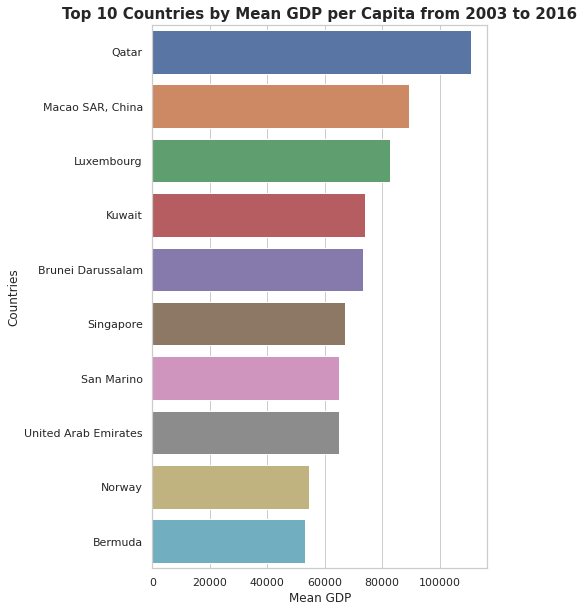

In [75]:
# Plot the mean GPD per Capita in 2016 by country
x = describe_GDP_per_capita_country[('mean')].head(10)
y = describe_GDP_per_capita_country.index[:10]
title = "Top 10 Countries by Mean GDP per Capita from 2003 to 2016"
xlabel = "Mean GDP"
ylabel = "Countries"
figsize=(6,10)
plot_barplot(x, y, title, xlabel, ylabel, rotation=0, figsize=figsize)

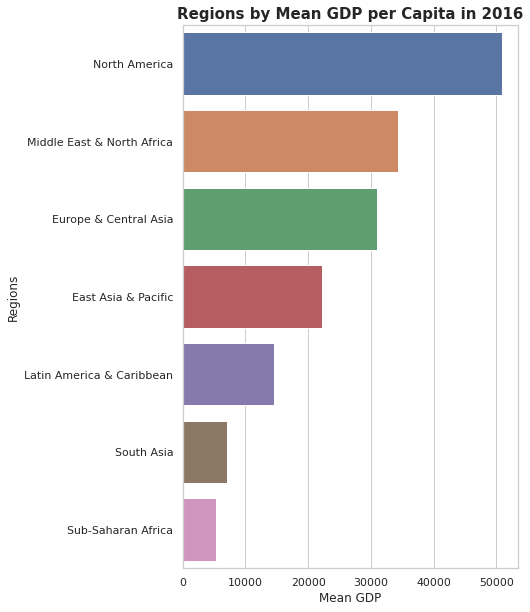

In [76]:
# Plot the mean GPD per Capita in 2016 by region
x = describe_GDP_per_capita_region[('2016', 'mean')].head(10)
y = describe_GDP_per_capita_region.index[:10]
title = "Regions by Mean GDP per Capita in 2016"
xlabel = "Mean GDP"
ylabel = "Regions"
figsize=(6,10)
plot_barplot(x, y, title, xlabel, ylabel, rotation=0, figsize=figsize)

### Analyse du Top 10

In [77]:
# Get top 10 countries by evolution and year 2016
df_GDP_per_capita_evolution_top10, df_GDP_per_capita_2016_top10 = sort_top_10(
    df_GDP_per_capita
)

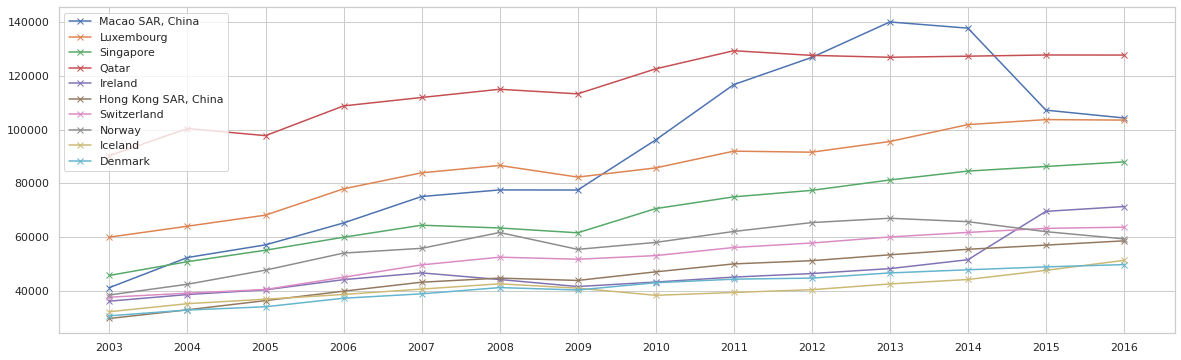

In [78]:
# Visualize top 10 evolution countires in terms of GDP per capita
plot_indicator(df_GDP_per_capita_evolution_top10, begin=3, legend=True)

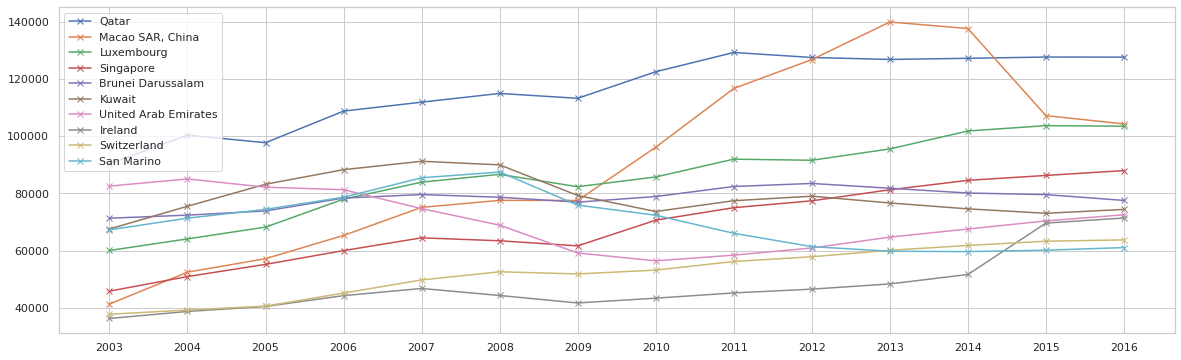

In [79]:
# Visualize top 10 GDP per capita countires in year 2016
plot_indicator(df_GDP_per_capita_2016_top10, begin=3, legend=True)

In [80]:
# Create a set of countries that are top 10 evolution and top 10 in year 2016
top_GDP_per_capita_common_countries_set = set(
    df_GDP_per_capita_evolution_top10.CountryName
) & set(df_GDP_per_capita_2016_top10.CountryName)
top_GDP_per_capita_common_countries_set

{'Ireland',
 'Luxembourg',
 'Macao SAR, China',
 'Qatar',
 'Singapore',
 'Switzerland'}

In [81]:
# Use the set to create a filter
top_GDP_per_capita_common_countries_set_filter_str = (
    str(top_GDP_per_capita_common_countries_set).replace("', '", "|").strip("{}'")
)

In [82]:
# Take away extra countires in the df_population dataframe
print(
    f"df_GDP_per_capita_evolution_top10 size before filter: ",
    f"{df_GDP_per_capita_evolution_top10.shape}",
)
# df_population_minus_extra_countries = df_populatio
df_GDP_per_capita_evolution_and_2016_top10 = df_GDP_per_capita_evolution_top10[
    df_GDP_per_capita_evolution_top10.CountryName.str.contains(
        top_GDP_per_capita_common_countries_set_filter_str
    )
]
print(
    f"df_GDP_per_capita_evolution_and_2016_top10 size before filter: ",
    f"{df_GDP_per_capita_evolution_and_2016_top10.shape}",
)

df_GDP_per_capita_evolution_top10 size before filter:  (10, 18)
df_GDP_per_capita_evolution_and_2016_top10 size before filter:  (6, 18)


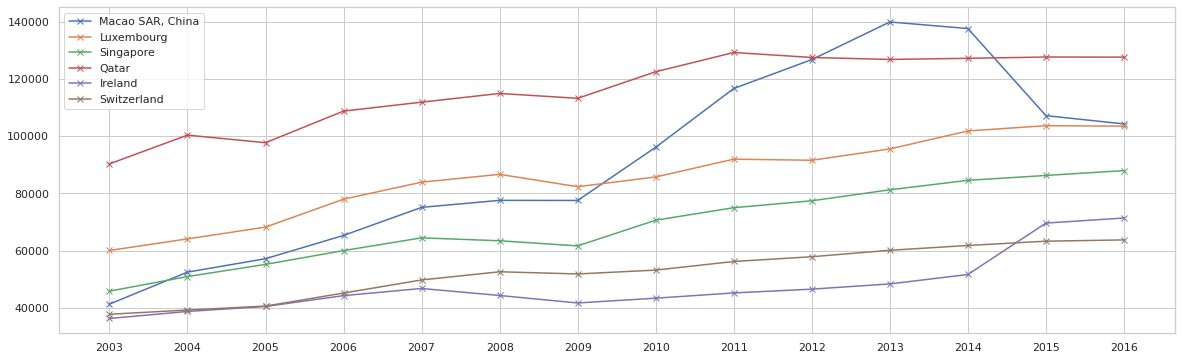

In [83]:
# Visualize the countries that top 10 by GDP per capita
# in both year 2016 and evolution between 2003 and 2016
plot_indicator(df_GDP_per_capita_evolution_and_2016_top10, begin=3, legend=True)

**<ins> Remarques </ins>**<br>
L'Irlande, le Luxembourg, la RAS de Macao, le Qatar, Singapour et la Suisse sont les 6 pays qui figurent parmi les pays les plus évolutifs entre 2003 et 2016 ainsi qu'en 2016 en termes de PIB (PPA) par habitant.<br>
C'est un indicateur plus fiable par rapport à PIB seul puisqu'il signifie le pouvoir d'achat par habitant.

### Carte

In [84]:
# Create DataFrame for the map
df_map = pd.DataFrame(columns=["CountryCode", "2016+evo"])
df_map.CountryCode = df_GDP_per_capita.CountryCode
df_map['2016+evo'] = df_GDP_per_capita['2016'] + df_GDP_per_capita.evolution

In [85]:
# Import base world map
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
world_geo = f"{url}/world-countries.json"
# Assign data map
world_data = df_map

bins = list(world_data['2016+evo'].quantile([0, 0.7, 0.9, 0.975, 1]))

# Create base map with France in the center of the map
m = folium.Map(location=[46.227638, 2.213749], zoom_start=2)

# Map GDP per capita on the map
folium.Choropleth(
    geo_data=world_geo,
    name="choropleth",
    data=world_data,
    columns=["CountryCode", "2016+evo"],
    key_on="feature.id",
    fill_color="YlOrRd",
    nan_fill_color='white',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="GDP Evolution between 2003 and 2016",
    bins=bins
).add_to(m)

folium.LayerControl().add_to(m)

m

## Ordinateurs et Internet

Étant donné que notre entreprise, **academy**, a pour but de fournir une formation *en ligne* aux lycéens et aux étudiants universitaires, nous devons vérifier si ces pays satisfont aux exigences en matière de **possession d'un ordinateur** et d'**accès à l'Internet**.

In [86]:
# Create computer ownerhsip and internet access dataframes with filters
df_computer = filter_indicator_by_name(df_data, "computers")
df_internet = filter_indicator_by_name(df_data, keyword="Internet")

In [87]:
# Check dataframes size
print(df_computer.shape)
print(df_internet.shape)

(218, 19)
(233, 19)


In [88]:
# Make sure that the dataframes do not have duplicate 'CountryName'
print(df_computer.CountryName.nunique())
print(df_internet.CountryName.nunique())

218
233


### Propriété des ordinateurs

In [89]:
df_computer.head(2)

,CountryName,CountryCode,IndicatorName,IndicatorCode,Region,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
245,Arab World,ARB,Personal computers (per 100 people),IT.CMP.PCMP.P2,NaN,3.401317,3.979838,5.305007,6.676681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,East Asia & Pacific,EAS,Personal computers (per 100 people),IT.CMP.PCMP.P2,NaN,8.290790,6.069233,6.937880,7.953008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
# Create a dataframe with computer ownership counts per year
df_computer_count = pd.DataFrame(columns=['counts'])
for column in df_data.columns[5:]:
    df_computer_count.loc[column] = df_computer[str(column)].notnull().sum()
df_computer_count = count_per_year(df_computer)

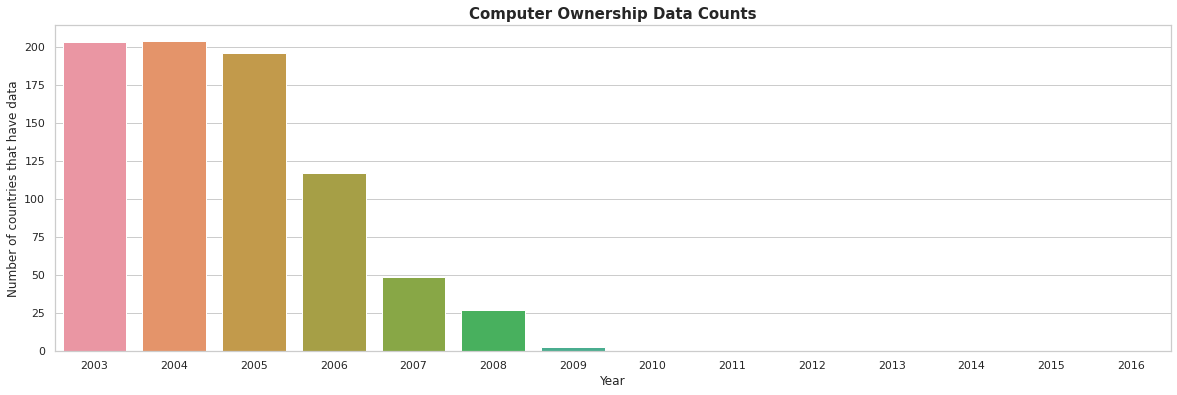

In [91]:
# Plot the number of valid values per year
x = df_computer_count.index
y = df_computer_count.counts
title = "Computer Ownership Data Counts"
xlabel = "Year"
ylabel = "Number of countries that have data"
plot_barplot(x=x, y=y, title=title, xlabel=xlabel, ylabel=ylabel)

** <ins>Remarque </ins> **
1. A partir de 2007, il y avait beaucoup moins de données.
2. Plus aucune donnée après 2010.

Cela est probablement dû à la sortie du smartphone et de la tablette en 2007 et 2010 respectivement, <br>qui ont profondément changé le comportement de possession d'appareils partout dans le monde.

### Accès à l'Internet

In [92]:
# Create a dataframe with internet access counts per year
df_internet_count = count_per_year(df_internet, begin=5, end=-1, sum_value=True)

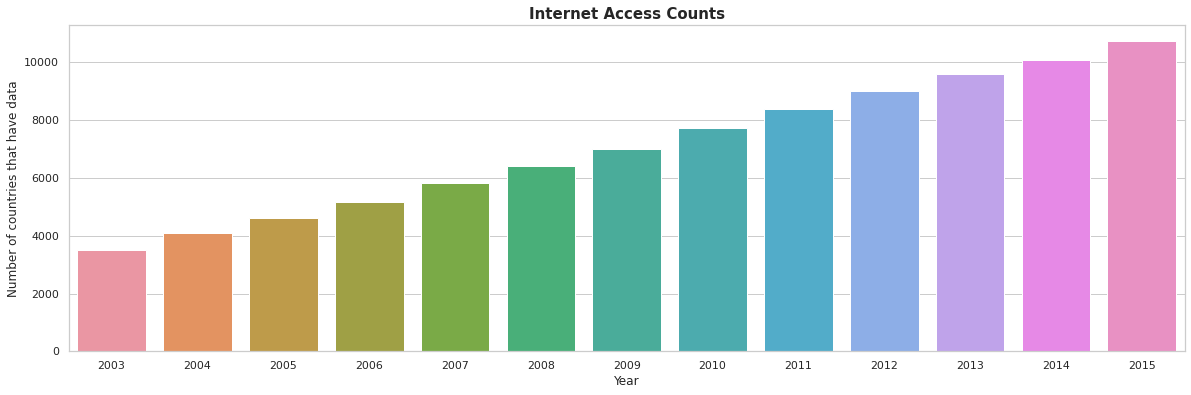

In [93]:
# Plot the number of valid values per year
x = df_internet_count.index
y = df_internet_count.counts
title = "Internet Access Counts"
xlabel = "Year"
ylabel = "Number of countries that have data"
plot_barplot(x=x, y=y, title=title, xlabel=xlabel, ylabel=ylabel)

** <ins>Remarques </ins> ** <br>
Lorsque nous regardons les données sur l'accès à Internet, nous pouvons voir que presque tous les pays augmentent régulièrement, certains progressent plus vite que d'autres.

#### Analyse des Indicateurs Statistiques Classiques

In [94]:
# Calculate evolution between 2003 and 2016
df_internet = insert_evolution(df_internet)

In [95]:
df_internet.head(1)

,CountryName,CountryCode,IndicatorName,IndicatorCode,Region,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,evolution
137,Arab World,ARB,Internet users (per 100 people),IT.NET.USER.P2,NaN,3.645881,7.006812,8.393142,11.654648,14.205902,18.593531,22.973689,26.747251,29.707761,34.014224,36.868602,NaN,NaN,NaN,NaN


In [96]:
# Calculate classic statistic indicators by country and region
columns_to_drop = ["CountryCode", "IndicatorName", "IndicatorCode", "Region"]
describe_internet_country, describe_internet_region = get_classic_statistics(
    df_internet, columns_to_drop
)

In [97]:
describe_internet_country.head()

,mean,std,50%
CountryName,,,
Iceland,87.253088,20.561417,93.00
Norway,85.073338,19.437446,92.08
Denmark,83.925720,18.507043,86.84
Sweden,83.757829,20.253083,90.00
Netherlands,81.950607,17.754005,89.63


In [98]:
describe_internet_region

2016                        evolution  \
                                 mean        std        50%       mean   
Region                                                                   
North America               88.005579  11.026673  89.840000  27.199203   
Europe & Central Asia       74.786072  18.225229  76.409085  42.319067   
Middle East & North Africa  57.957443  25.716167  61.178385  47.918402   
Latin America & Caribbean   55.996939  18.057180  58.136494  42.993696   
East Asia & Pacific         49.742741  27.597251  46.500000  32.995967   
South Asia                  28.313673  16.024294  24.617963  26.159384   
Sub-Saharan Africa          20.312099  14.590605  18.000000  18.835532   

                                                  
                                  std        50%  
Region                                            
North America               13.566551  25.640000  
Europe & Central Asia       16.125069  43.643711  
Middle East & North Africa  18.919004  53.836188  
Latin America & Caribbean   12.826556  44.853837  
East Asia & Pacific         13.730232  27.507646  
South Asia                  14.765012  23.583313  
Sub-Saharan Africa          12.364496  17.338848

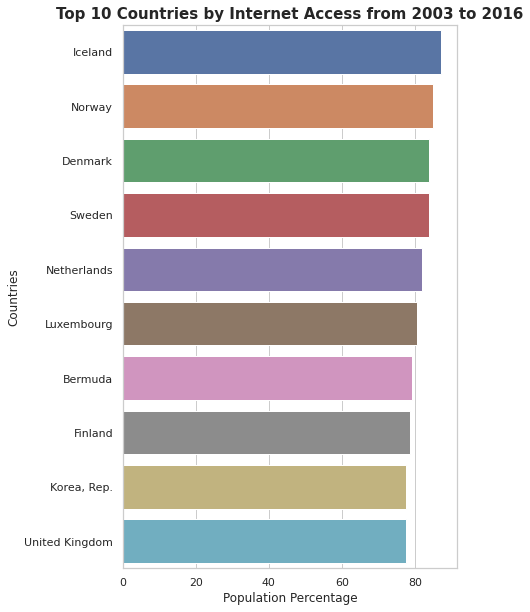

In [99]:
# Plot the mean internet access in 2016 by country
x = describe_internet_country[('mean')].head(10)
y = describe_internet_country.index[:10]
title = "Top 10 Countries by Internet Access from 2003 to 2016"
xlabel = "Population Percentage"
ylabel = "Countries"
figsize=(6,10)
plot_barplot(x, y, title, xlabel, ylabel, rotation=0, figsize=figsize)

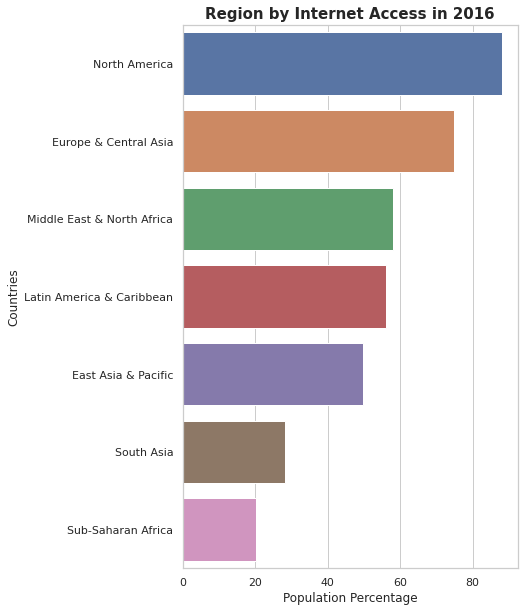

In [100]:
# Plot the mean internet access in 2016 by region
x = describe_internet_region[('2016', 'mean')].head(10)
y = describe_internet_region.index[:10]
title = "Region by Internet Access in 2016"
xlabel = "Population Percentage"
ylabel = "Countries"
figsize=(6,10)
plot_barplot(x, y, title, xlabel, ylabel, rotation=0, figsize=figsize)

####  Analyse du Top 10

In [101]:
df_internet.head(2)

,CountryName,CountryCode,IndicatorName,IndicatorCode,Region,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,evolution
137,Arab World,ARB,Internet users (per 100 people),IT.NET.USER.P2,NaN,3.645881,7.006812,8.393142,11.654648,14.205902,18.593531,22.973689,26.747251,29.707761,34.014224,36.868602,NaN,NaN,NaN,NaN
506,East Asia & Pacific,EAS,Internet users (per 100 people),IT.NET.USER.P2,NaN,10.547244,12.596964,14.666359,16.617828,20.766523,25.253566,29.513198,34.230838,37.365156,40.709345,44.577349,46.812103,49.787924,52.796321,42.249077


In [102]:
# Calculate evolution between 2003 and 2016
df_internet = insert_evolution(df_internet)

In [103]:
# Get top 10 countries by evolution and year 2016
df_internet_evolution_top10, df_internet_2016_top10 = sort_top_10(df_internet)

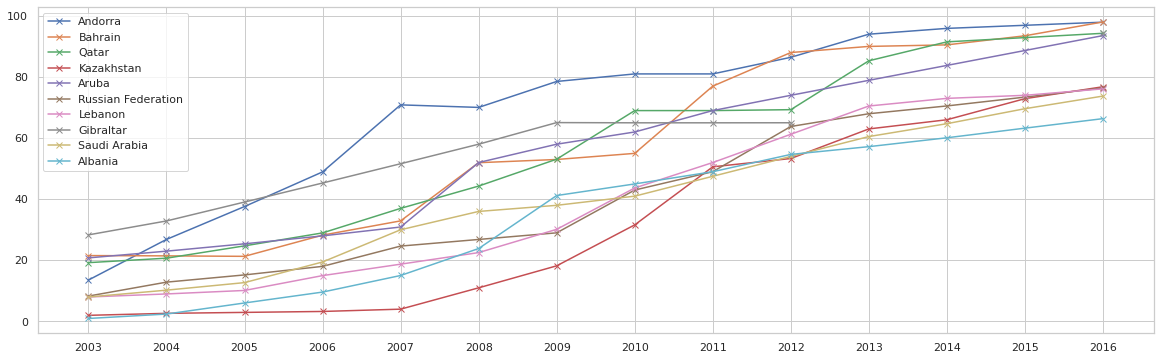

In [104]:
# Visualize top 10 evolution countires
plot_indicator(df_internet_evolution_top10, legend=True)

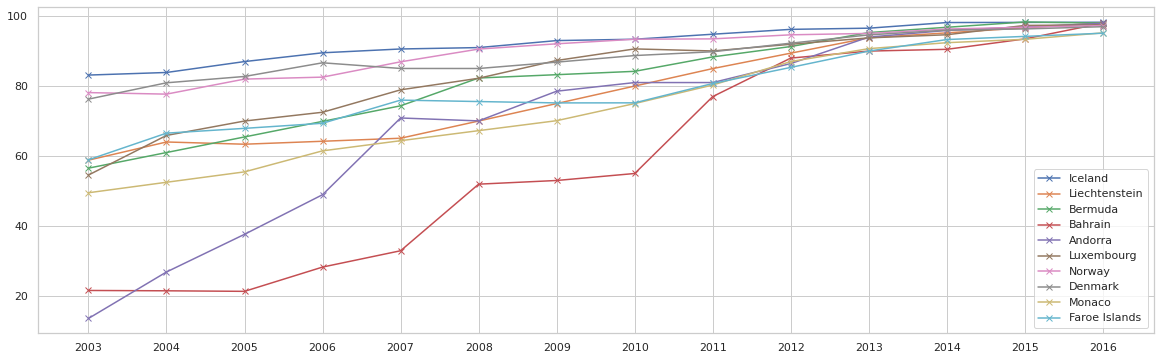

In [105]:
# Visualize top 10 countires in 2016
plot_indicator(df_internet_2016_top10, legend=True)

In [106]:
df_internet_evolution_top10_set = set(df_internet_evolution_top10.CountryName)
df_internet_2016_top10_set = set(df_internet_2016_top10.CountryName)

In [107]:
# Top countries in evoluted internet access but not 
# in the top 10 internet access in 2016
df_internet_evolution_top10_set - df_internet_2016_top10_set

{'Albania',
 'Aruba',
 'Gibraltar',
 'Kazakhstan',
 'Lebanon',
 'Qatar',
 'Russian Federation',
 'Saudi Arabia'}

In [108]:
# Countries that are both in the top 10 evoluted internet access 
# between 2003 & 2016 and in the top 10 internet access in 2016
df_internet_evolution_top10_set & df_internet_2016_top10_set

{'Andorra', 'Bahrain'}

#### Analyse des Tops Pays par PIB(PPA) par Habitant

In [109]:
# Use the 'top_GDP_per_capita_common_countries_set' set to create a filter
top_GDP_per_capita_common_countries_filter_str = (
    str(top_GDP_per_capita_common_countries_set).replace("', '", "|").strip("{}'")
)
top_GDP_per_capita_common_countries_filter_str

'Macao SAR, China|Ireland|Switzerland|Singapore|Qatar|Luxembourg'

In [110]:
# Check Internet Access of the top GDP per capita countries
df_internet_top_GDP_per_head = df_internet[
    df_internet.CountryName.str.contains(top_GDP_per_capita_common_countries_filter_str)
]
df_internet_top_GDP_per_head_sorted = df_internet_top_GDP_per_head.sort_values(
    by="2016", ascending=False
)
df_internet_top_GDP_per_head_sorted

,CountryName,CountryCode,IndicatorName,IndicatorCode,Region,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,evolution
195199,Luxembourg,LUX,Internet users (per 100 people),IT.NET.USER.P2,Europe & Central Asia,54.550000,65.880000,70.000000,72.510000,78.920000,82.23,87.31,90.620,90.029859,91.949924,93.776500,94.670000,97.334100,97.493930,42.943930
264822,Qatar,QAT,Internet users (per 100 people),IT.NET.USER.P2,Middle East & North Africa,19.242336,20.701648,24.733494,28.974113,37.000000,44.30,53.10,69.000,69.000000,69.300000,85.300000,91.490000,92.884826,94.291118,75.048782
310015,Switzerland,CHE,Internet users (per 100 people),IT.NET.USER.P2,Europe & Central Asia,65.100000,67.800000,70.100000,75.700000,77.200000,79.20,81.30,83.900,85.193028,85.200000,86.340000,87.400000,87.479056,89.405568,24.305568
157757,Ireland,IRL,Internet users (per 100 people),IT.NET.USER.P2,Europe & Central Asia,34.310000,36.990000,41.610000,54.820000,61.158325,65.34,67.38,69.850,74.889973,76.919993,78.247700,79.690000,80.122400,82.169700,47.859700
196994,"Macao SAR, China",MAC,Internet users (per 100 people),IT.NET.USER.P2,East Asia & Pacific,25.742124,31.484097,34.862927,46.400000,47.327000,49.24,54.00,55.198,60.203697,61.310000,65.800000,69.780000,77.600132,81.642985,55.900861
285509,Singapore,SGP,Internet users (per 100 people),IT.NET.USER.P2,East Asia & Pacific,53.837943,62.000000,61.000000,59.000000,69.900000,69.00,69.00,71.000,71.000000,72.000000,80.902057,79.029236,79.012957,81.000000,27.162057


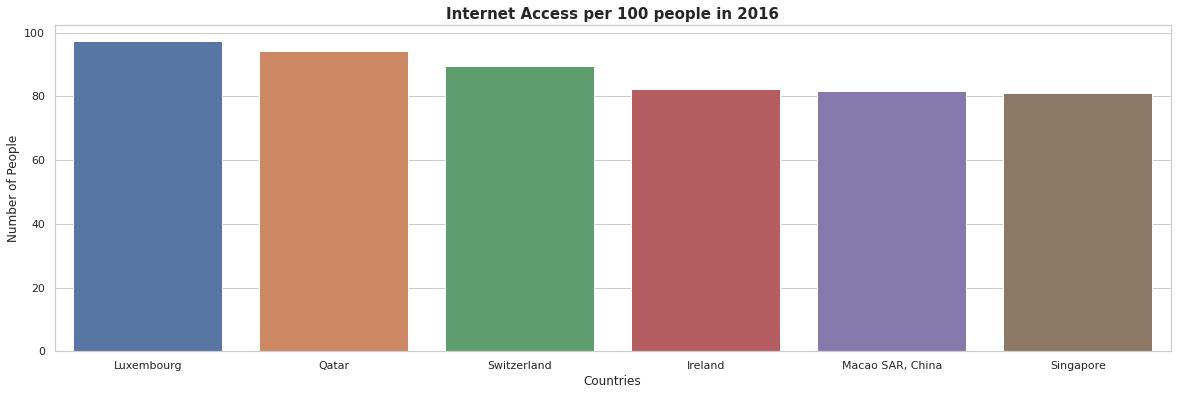

In [111]:
# plot the internet access per country for the top 6 GDP per capita countries
x = df_internet_top_GDP_per_head_sorted.CountryName
y = df_internet_top_GDP_per_head_sorted["2016"]
title = "Internet Access per 100 people in 2016"
xlabel = "Countries"
ylabel = "Number of People"
plot_barplot(x=x, y=y, title=title, xlabel=xlabel, ylabel=ylabel)

**<ins> Remarques</ins>**<br>
Parmi les 6 pays identifiés par le PIB par habitant, le Luxembourg, le Qatar et la Suisse ont le plus haut niveau d'accès à Internet. Nous pouvons nous concentrer et commencer par ces 3 pays.

## Niveau d'Education

In [112]:
# Get population percentage that complete primary education.
keyword = r"Percentage of population age 15\+ with primary schooling. Completed Primary"
df_population_primary = filter_indicator_by_name(df_data, keyword)
df_population_primary_top_GDP_per_head = df_population_primary[
    df_population_primary.CountryName.str.contains(
        top_GDP_per_capita_common_countries_filter_str
    )
]
df_population_primary_top_GDP_per_head

,CountryName,CountryCode,IndicatorName,IndicatorCode,Region,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
157354,Ireland,IRL,Barro-Lee: Percentage of population age 15+ with primary schooling...,BAR.PRM.CMPT.15UP.ZS,Europe & Central Asia,NaN,NaN,13.72,NaN,NaN,NaN,NaN,13.86,NaN,NaN,NaN,NaN,NaN,NaN
194794,Luxembourg,LUX,Barro-Lee: Percentage of population age 15+ with primary schooling...,BAR.PRM.CMPT.15UP.ZS,Europe & Central Asia,NaN,NaN,19.48,NaN,NaN,NaN,NaN,15.71,NaN,NaN,NaN,NaN,NaN,NaN
196595,"Macao SAR, China",MAC,Barro-Lee: Percentage of population age 15+ with primary schooling...,BAR.PRM.CMPT.15UP.ZS,East Asia & Pacific,NaN,NaN,20.85,NaN,NaN,NaN,NaN,16.16,NaN,NaN,NaN,NaN,NaN,NaN
264428,Qatar,QAT,Barro-Lee: Percentage of population age 15+ with primary schooling...,BAR.PRM.CMPT.15UP.ZS,Middle East & North Africa,NaN,NaN,4.41,NaN,NaN,NaN,NaN,18.48,NaN,NaN,NaN,NaN,NaN,NaN
285183,Singapore,SGP,Barro-Lee: Percentage of population age 15+ with primary schooling...,BAR.PRM.CMPT.15UP.ZS,East Asia & Pacific,NaN,NaN,20.34,NaN,NaN,NaN,NaN,4.09,NaN,NaN,NaN,NaN,NaN,NaN
309598,Switzerland,CHE,Barro-Lee: Percentage of population age 15+ with primary schooling...,BAR.PRM.CMPT.15UP.ZS,Europe & Central Asia,NaN,NaN,15.92,NaN,NaN,NaN,NaN,2.49,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
# Get population percentage that complete secondary education.
keyword = (
    r"Percentage of population age 15\+ with secondary schooling. Completed Secondary"
)
df_population_secondary = filter_indicator_by_name(df_data, keyword)
df_population_secondary_top_GDP_per_head = df_population_secondary[
    df_population_secondary.CountryName.str.contains(
        top_GDP_per_capita_common_countries_filter_str
    )
]
df_population_secondary_top_GDP_per_head

,CountryName,CountryCode,IndicatorName,IndicatorCode,Region,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
157356,Ireland,IRL,Barro-Lee: Percentage of population age 15+ with secondary schooli...,BAR.SEC.CMPT.15UP.ZS,Europe & Central Asia,NaN,NaN,29.98,NaN,NaN,NaN,NaN,24.69,NaN,NaN,NaN,NaN,NaN,NaN
194796,Luxembourg,LUX,Barro-Lee: Percentage of population age 15+ with secondary schooli...,BAR.SEC.CMPT.15UP.ZS,Europe & Central Asia,NaN,NaN,28.47,NaN,NaN,NaN,NaN,27.58,NaN,NaN,NaN,NaN,NaN,NaN
196597,"Macao SAR, China",MAC,Barro-Lee: Percentage of population age 15+ with secondary schooli...,BAR.SEC.CMPT.15UP.ZS,East Asia & Pacific,NaN,NaN,25.99,NaN,NaN,NaN,NaN,32.11,NaN,NaN,NaN,NaN,NaN,NaN
264430,Qatar,QAT,Barro-Lee: Percentage of population age 15+ with secondary schooli...,BAR.SEC.CMPT.15UP.ZS,Middle East & North Africa,NaN,NaN,22.91,NaN,NaN,NaN,NaN,23.57,NaN,NaN,NaN,NaN,NaN,NaN
285185,Singapore,SGP,Barro-Lee: Percentage of population age 15+ with secondary schooli...,BAR.SEC.CMPT.15UP.ZS,East Asia & Pacific,NaN,NaN,29.90,NaN,NaN,NaN,NaN,30.00,NaN,NaN,NaN,NaN,NaN,NaN
309600,Switzerland,CHE,Barro-Lee: Percentage of population age 15+ with secondary schooli...,BAR.SEC.CMPT.15UP.ZS,Europe & Central Asia,NaN,NaN,36.22,NaN,NaN,NaN,NaN,48.33,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
# Get population percentage that complete tertiary education.
keyword = (
    r"Percentage of population age 15\+ with tertiary schooling. Completed Tertiary"
)
df_population_tertiary = filter_indicator_by_name(df_data, keyword)
df_population_tertiary_top_GDP_per_head = df_population_tertiary[
    df_population_tertiary.CountryName.str.contains(
        top_GDP_per_capita_common_countries_filter_str
    )
]
df_population_tertiary_top_GDP_per_head

,CountryName,CountryCode,IndicatorName,IndicatorCode,Region,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
157358,Ireland,IRL,Barro-Lee: Percentage of population age 15+ with tertiary schoolin...,BAR.TER.CMPT.15UP.ZS,Europe & Central Asia,NaN,NaN,20.47,NaN,NaN,NaN,NaN,26.80,NaN,NaN,NaN,NaN,NaN,NaN
194798,Luxembourg,LUX,Barro-Lee: Percentage of population age 15+ with tertiary schoolin...,BAR.TER.CMPT.15UP.ZS,Europe & Central Asia,NaN,NaN,13.29,NaN,NaN,NaN,NaN,18.54,NaN,NaN,NaN,NaN,NaN,NaN
196599,"Macao SAR, China",MAC,Barro-Lee: Percentage of population age 15+ with tertiary schoolin...,BAR.TER.CMPT.15UP.ZS,East Asia & Pacific,NaN,NaN,6.90,NaN,NaN,NaN,NaN,10.43,NaN,NaN,NaN,NaN,NaN,NaN
264432,Qatar,QAT,Barro-Lee: Percentage of population age 15+ with tertiary schoolin...,BAR.TER.CMPT.15UP.ZS,Middle East & North Africa,NaN,NaN,10.55,NaN,NaN,NaN,NaN,10.05,NaN,NaN,NaN,NaN,NaN,NaN
285187,Singapore,SGP,Barro-Lee: Percentage of population age 15+ with tertiary schoolin...,BAR.TER.CMPT.15UP.ZS,East Asia & Pacific,NaN,NaN,13.70,NaN,NaN,NaN,NaN,29.71,NaN,NaN,NaN,NaN,NaN,NaN
309602,Switzerland,CHE,Barro-Lee: Percentage of population age 15+ with tertiary schoolin...,BAR.TER.CMPT.15UP.ZS,Europe & Central Asia,NaN,NaN,12.80,NaN,NaN,NaN,NaN,17.88,NaN,NaN,NaN,NaN,NaN,NaN


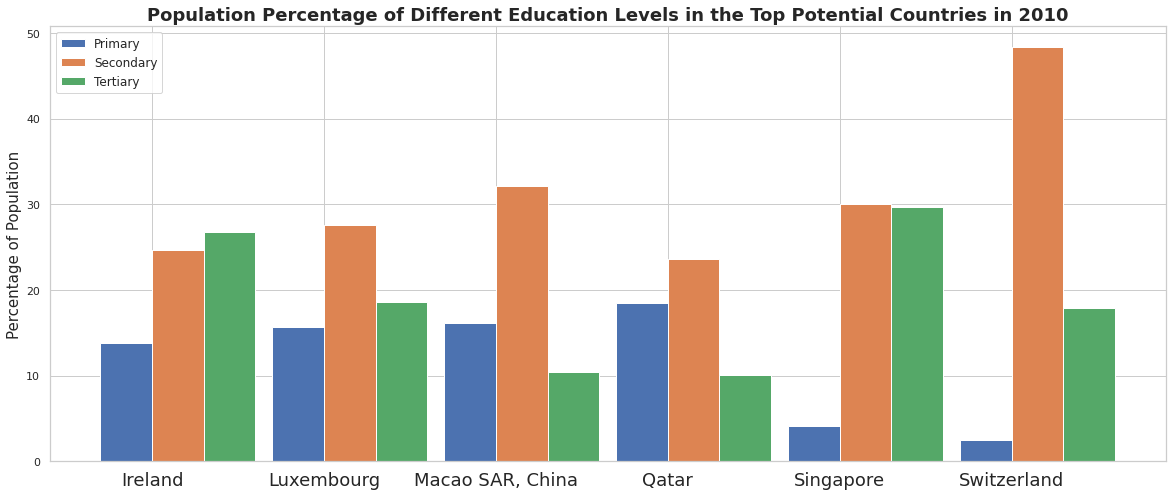

In [115]:
# Plot different education levels per country
# for the top 6 GPD per captia countries
N = len(df_population_primary_top_GDP_per_head)
ind = np.arange(N)  # the x locations for the groups
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 8))
rects1 = ax.bar(ind, df_population_primary_top_GDP_per_head["2010"], width)
rects2 = ax.bar(ind + width, df_population_secondary_top_GDP_per_head["2010"], width)
rects3 = ax.bar(ind + width * 2, df_population_tertiary_top_GDP_per_head["2010"], width)

# Add y labels and  title
ax.set_ylabel(
    "Percentage of Population", fontdict={"fontsize": 15, "fontweight": "medium"}
)
ax.set_title(
    "Population Percentage of Different Education Levels in the Top Potential Countries in 2010",
    fontdict={"fontsize": 18, "fontweight": "heavy"},
)

# Set axes x ticks, its labels and legend
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(
    (df_population_secondary_top_GDP_per_head.CountryName),
    fontdict={"fontsize": 18, "fontweight": "medium"},
)

ax.legend(
    (rects1[0], rects2[0], rects3[0]),
    ("Primary", "Secondary", "Tertiary"),
    fontsize="large",
)
plt.show()

**<ins> Remarques </ins>** <br>
Les principaux pays avec le PIB par habitant le plus élevé sont: le Luxembourg, le Qatar, la Suisse, l’Irlande, Macao et Singapour.
1. Lorsque l'on examine les niveaux d'éducation dans chacun de ces pays, les pays qui ont le plus de potentiel sont : la Suisse, la RAS de Macao, le Qatar et le Luxembourg. Dans ces pays, l'écart en pourcentage de la population entre le lycée et l'université est le plus important. Cela nous donne l'occasion de proposer nos services pour combler ces écarts.
2. Parmi les pays ayant le PIB par habitant et l'accès à Internet les plus élevés, les pays qui ont le plus potentiel sont : le Luxembourg, le Qatar et la Suisse.
3. Par conséquent, nous pouvons commencer par la Suisse et le Luxembourg, car ils sont tous les deux situés en Europe, sur le même continent que notre siège social. Ensuite, nous pourrons nous étendre au Qatar pour aller plus loin.

# Annexe

## Évolution Future

In [116]:
# df_data = pd.read_csv("data/dataframes/df_data_no_more_full_null.csv")

In [117]:
# Set keywords
keyword_GDP = '(?=.*GDP, PPP)(?=.*current)'
# Filter dataframe according to the keywords set
df_GDP_PPP_full = filter_indicator_by_name(df_data, keyword_GDP)

In [118]:
# Set keywords
keyword_population = 'Population, total'
# Filter dataframe according to the keywords set
df_population_full = filter_indicator_by_name(df_data, keyword_population)

In [119]:
print(df_GDP_PPP_full.shape)
df_population_full.shape

(217, 19)


(240, 19)

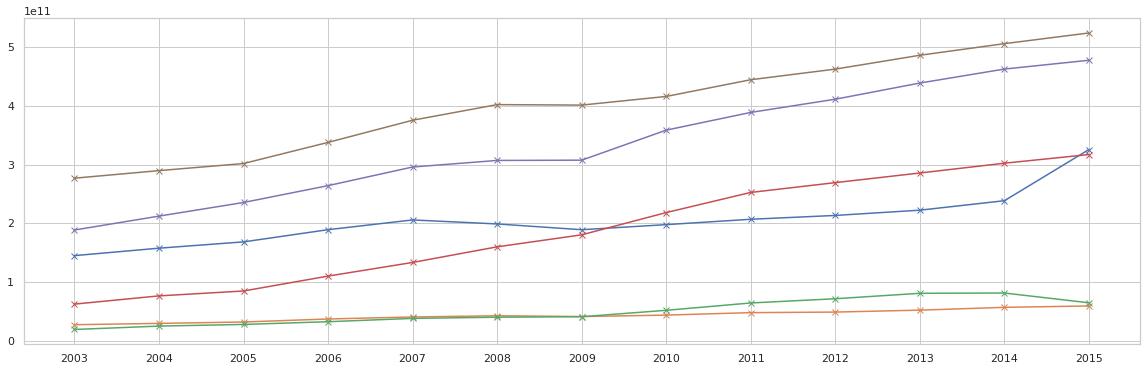

In [120]:
# Check Internet Access of the top GDP per capita countries
df_GDP_PPP_full_top_GDP_per_head = df_GDP_PPP_full[
    df_GDP_PPP_full.CountryName.str.contains(
        top_GDP_per_capita_common_countries_filter_str
    )
]
plot_indicator(df_GDP_PPP_full_top_GDP_per_head)

In [121]:
# Check Internet Access of the top GDP per capita countries
df_population_full_top_GDP_per_head = df_population_full[
    df_population_full.CountryName.str.contains(
        top_GDP_per_capita_common_countries_filter_str
    )
]
df_population_full_top_GDP_per_head.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Region,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
158475,Ireland,IRL,"Population, total",SP.POP.TOTL,Europe & Central Asia,3996521.0,4070262.0,4159914.0,4273591.0,4398942.0,4489544.0,4535375.0,4560155.0,4576794.0,4586897.0,4598294.0,4617225.0,4676835.0,4773095.0
195813,Luxembourg,LUX,"Population, total",SP.POP.TOTL,Europe & Central Asia,451630.0,458095.0,465158.0,472637.0,479993.0,488650.0,497783.0,506953.0,518347.0,530946.0,543360.0,556319.0,569604.0,582972.0
197619,"Macao SAR, China",MAC,"Population, total",SP.POP.TOTL,East Asia & Pacific,460147.0,471453.0,482559.0,493320.0,503823.0,514348.0,525313.0,536969.0,549439.0,562531.0,575841.0,588781.0,600942.0,612167.0
265471,Qatar,QAT,"Population, total",SP.POP.TOTL,Middle East & North Africa,688586.0,758855.0,864863.0,1010382.0,1189633.0,1389342.0,1590780.0,1779676.0,1952054.0,2109568.0,2250473.0,2374419.0,2481539.0,2569804.0
286113,Singapore,SGP,"Population, total",SP.POP.TOTL,East Asia & Pacific,4114826.0,4166664.0,4265762.0,4401365.0,4588599.0,4839396.0,4987573.0,5076732.0,5183688.0,5312437.0,5399162.0,5469724.0,5535002.0,5607283.0


**<ins>Remarques</ins>**<br>
Aucune évolution future ne peut être analysée en raison de données manquantes.

## Valeurs Aberrantes

In [122]:
df_data_outlier = pd.read_csv("data/dataframes/df_data_no_more_full_null.csv")

In [123]:
# Calculate evolution between 2010 and 2100 and add it to the dataframe
df_data_outlier["evolution"] = df_data_outlier["2100"] - df_data_outlier["2010"]

In [124]:
# Sort by evolution column and get top 10
df_data_outlier_evolution_top10 = df_data_outlier.sort_values(
    by=["evolution"], ascending=False
).head(20)

# Sort by 2100 column and get top 10
df_data_outlier_2100_top10 = df_data_outlier.sort_values(
    by=["2100"], ascending=False
).head(20)

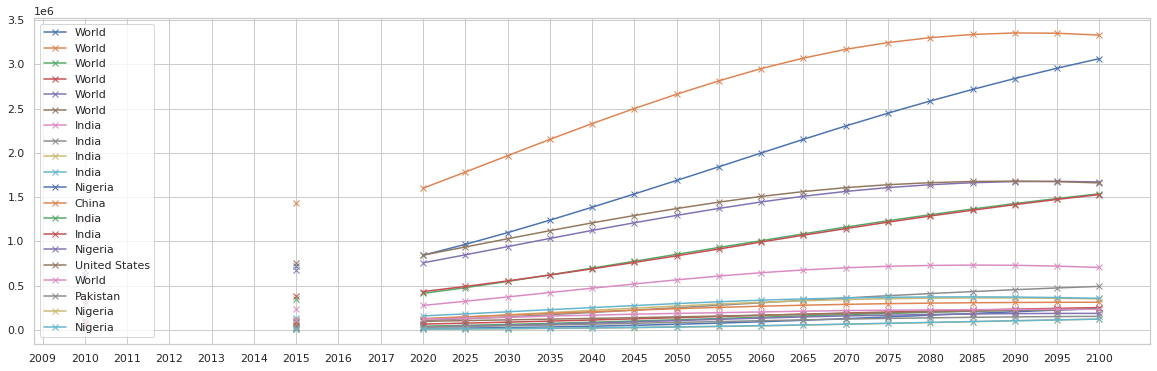

In [125]:
# Visualize top 10 evolution countires/regions
plot_indicator(df_data_outlier_evolution_top10, legend=True)

In [126]:
# Check which countries evolved the most
df_data_outlier_evolution_top10.CountryName.unique()

array(['World', 'India', 'Nigeria', 'China', 'United States', 'Pakistan'],
      dtype=object)

In [127]:
# Check which indicators evolved the most
df_data_outlier_evolution_top10.IndicatorName.unique()

array(['Wittgenstein Projection: Population in thousands by highest level of educational attainment. Post Secondary. Total',
       'Wittgenstein Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Total',
       'Wittgenstein Projection: Population in thousands by highest level of educational attainment. Post Secondary. Female',
       'Wittgenstein Projection: Population in thousands by highest level of educational attainment. Post Secondary. Male',
       'Wittgenstein Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Female',
       'Wittgenstein Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Male',
       'Wittgenstein Projection: Population age 25-29 in thousands by highest level of educational attainment. Post Secondary. Total'],
      dtype=object)

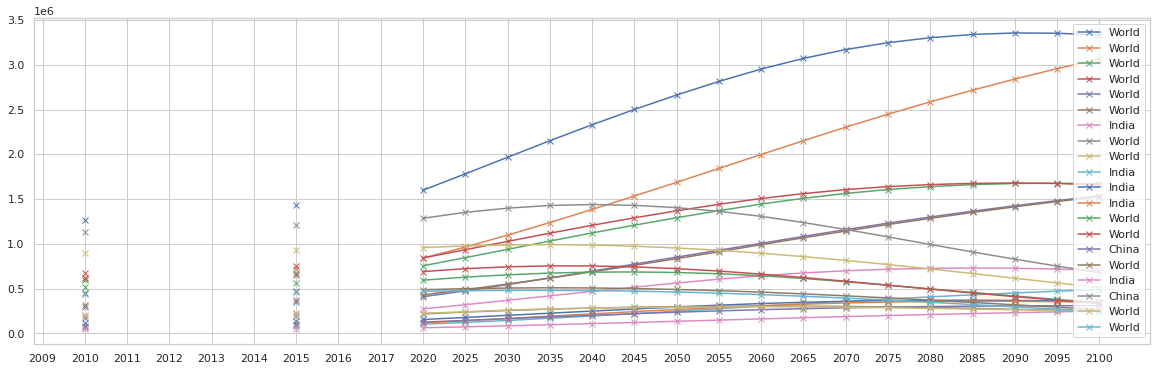

In [128]:
# Visualize top 10 countires/regions
plot_indicator(df_data_outlier_2100_top10, legend=True)

In [129]:
# Check top countries/regions in 2100
df_data_outlier_2100_top10.CountryName.unique()

array(['World', 'India', 'China'], dtype=object)

In [130]:
# Check top indicators in 2100
df_data_outlier_2100_top10.IndicatorName.unique()

array(['Wittgenstein Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Total',
       'Wittgenstein Projection: Population in thousands by highest level of educational attainment. Post Secondary. Total',
       'Wittgenstein Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Female',
       'Wittgenstein Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Male',
       'Wittgenstein Projection: Population in thousands by highest level of educational attainment. Post Secondary. Female',
       'Wittgenstein Projection: Population in thousands by highest level of educational attainment. Post Secondary. Male',
       'Wittgenstein Projection: Population in thousands by highest level of educational attainment. Lower Secondary. Total',
       'Wittgenstein Projection: Population in thousands by highest level of educational attainment. Primary. Total',
   

### Focus sur PIB

In [131]:
# Filter in only GDP indicator
keyword = '(?=.*GDP, PPP)(?=.*current)'
df_GDP_PPP_outlier = filter_indicator_by_name(df_data_outlier, keyword)

In [132]:
# Sort by evolution column and get top 10
df_GDP_PPP_outlier_evolution_top10 = df_GDP_PPP_outlier.sort_values(
    by=["evolution"], ascending=False
).head(10)

# Sort by 2010 column and get top 10
df_GDP_PPP_outlier_2100_top10 = df_GDP_PPP_outlier.sort_values(
    by=["2100"], ascending=False
).head(10)

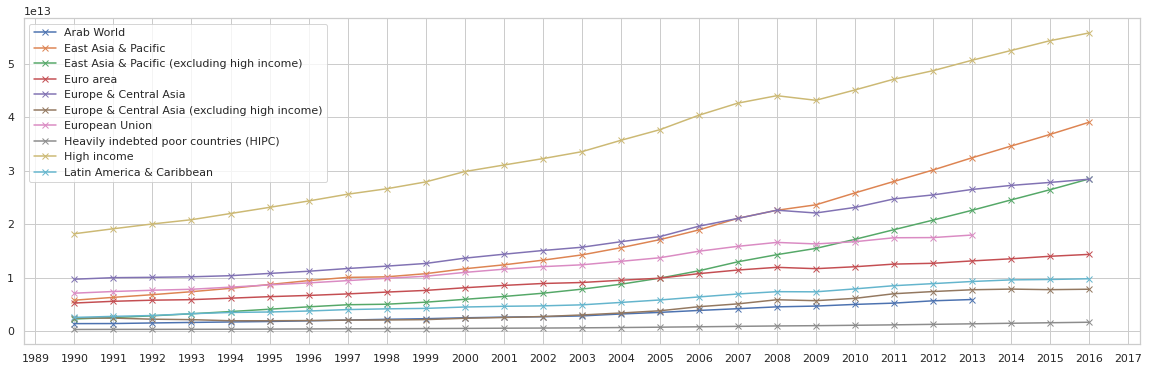

In [133]:
# Visualize top 10 evolved countries
plot_indicator(df_GDP_PPP_outlier_evolution_top10, legend=True)

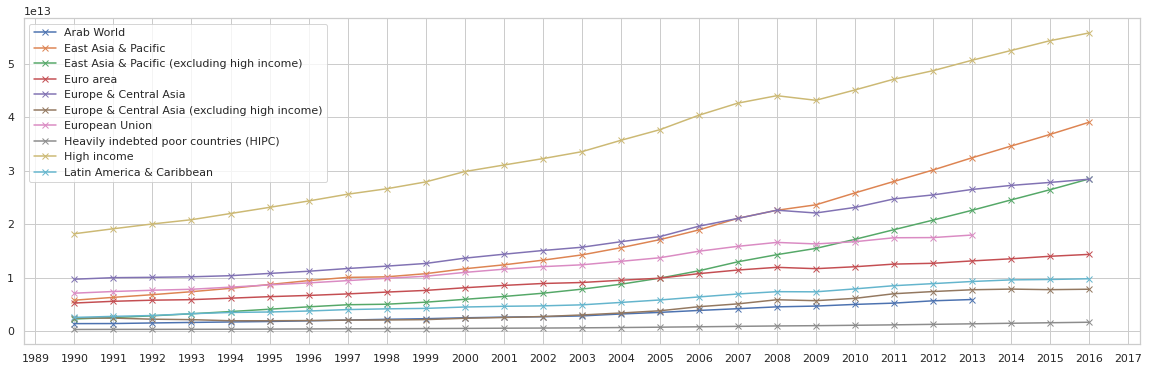

In [134]:
# Visualize top 10 countries in 2100
plot_indicator(df_GDP_PPP_outlier_2100_top10, legend=True)